In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import keras
%matplotlib inline  
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from scipy.io.wavfile import read
import scipy
from keras import layers
from keras.utils import to_categorical
import librosa
from sklearn.preprocessing import StandardScaler
from keras.layers import Lambda
from keras.models import load_model

Using TensorFlow backend.


First I begin by loading the file names into an easily referecible dataframe.

In [2]:
import os
rootdir = '/Users/johnminer/Desktop/term5/spd1.5/noise_generation'
file_names = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".wav"): 
            file_names.append(os.path.join(subdir, file))
            continue
        else:
            continue

In [3]:
df = pd.DataFrame()

In [4]:
df['File_names'] = file_names

In [5]:
genre = []
for i in file_names:
    cut_name = i[62:]
    name = ''
    for l in cut_name:
        if l == '/':
            break
        name += l
    genre.append(name)

In [6]:
df['Genre'] = genre

In [7]:
df.head()

,File_names,Genre
0,/Users/johnminer/Desktop/term5/spd1.5/noise_ge...,pop
1,/Users/johnminer/Desktop/term5/spd1.5/noise_ge...,pop
2,/Users/johnminer/Desktop/term5/spd1.5/noise_ge...,pop
3,/Users/johnminer/Desktop/term5/spd1.5/noise_ge...,pop
4,/Users/johnminer/Desktop/term5/spd1.5/noise_ge...,pop


Next I generate a pectogram to see how the data looks. I decided to go with the db type scpectrogram because it has more noticable features.

In [8]:
y, sr = librosa.load(df['File_names'][0])
spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)

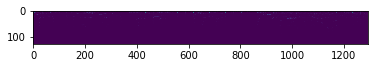

In [11]:
plt.imshow(spect)

In [445]:
spect = librosa.feature.melspectrogram(y=, sr=sr,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)

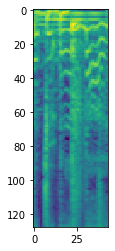

In [449]:
plt.imshow(spect)

get each song and break it down into 30 second labeled intervals then break each 30 interval into as many 6 second intervals as possible then transform it to a melspectogram

In [12]:
df['Genre'].unique()

array(['pop', 'metal', 'disco', 'blues', 'guitar', 'reggae', 'classical',
       'celtic', 'rock', 'hiphop', 'country', 'jazz'], dtype=object)

Later I decided to only use the celtic music to simplify what I was working with

In [13]:
def gen_spect(y):
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    return librosa.power_to_db(spect, ref=np.max)
def data_gen():
    all_data_list = []
    all_genre_list = []
    for i in range(1):
        class_df = df[df['Genre'] == 'celtic']
        for file in class_df['File_names']:
            try:
                y, sr = librosa.load(file)
                _min, _max = 0, 661500
                while True:
                    labeled_section = y[_min:_max]
                    subdivided_spects = []
                    _min_, _max_ = 0, 22050
                    while True:
                        subdivided = labeled_section[_min_:_max_]
                        subdivided_spects.append(gen_spect(subdivided))
                        if len(labeled_section) < _max_ + 22050:
                            break
                        _min_ += 22050
                        _max_ += 22050
                    if len(subdivided_spects) == 30:
                        for i in range(31):
                            if i >= 6:
                                all_data_list.append(subdivided_spects[i-6:i])
                                all_genre_list.append(i)
                    if len(y) < _max + 661500:
                        break
                    _min += 661500
                    _max += 661500
            except:
                pass
    return np.array(all_data_list), np.array(all_genre_list)

In [14]:
spect_data, spect_labels = data_gen()

In [17]:
data, labels =spect_data, spect_labels

Next we reshape the data into the proper format for the model.

In [15]:
spect_data.shape

(10625, 6, 128, 44)

In [18]:
data = data.reshape((10625, 6, 128, 44, 1))

In [24]:
data.shape

(10625, 6, 128, 44, 1)

Next I picklized the data for ease of access later

In [16]:
import pickle
with open('celtic.pickle', 'wb') as f:
    pickle.dump([spect_data, spect_labels], f)

In [576]:
with open('celtic.pickle', 'rb') as f:
    data, labels = pickle.load(f)

In [25]:
gen_data = data[:,:5]

In [581]:
gen_data.shape

(9330, 5, 128, 44, 1)

In [26]:
after_gen_data = data[:,5:]

In [585]:
after_gen_data.shape

(9330, 1, 128, 44, 1)

In [583]:
new_gen_data = data[:,:5]

In [584]:
new_gen_data.shape

(9330, 5, 128, 44, 1)

Next we encode the labels for the songs though I ended up not using these

In [588]:
encoded = to_categorical(labels)

In [590]:
len(gen_data1)

2125

First I built a discriminator model. The thing is that even with a large network it couldn't identify what samples were machine generated and what were real so eventually i had to scrap it.

In [548]:
model = keras.Sequential()
model.add(layers.LSTM(units=96, input_shape=(6, 5632)))
model.add(layers.Dense(1408))
model.add(layers.Dense(704))
model.add(layers.Dense(13))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 96)                2199936   
_________________________________________________________________
dense_120 (Dense)            (None, 1408)              136576    
_________________________________________________________________
dense_121 (Dense)            (None, 704)               991936    
_________________________________________________________________
dense_122 (Dense)            (None, 13)                9165      
_________________________________________________________________
activation_81 (Activation)   (None, 13)                0         
Total params: 3,337,613
Trainable params: 3,337,613
Non-trainable params: 0
_________________________________________________________________


In [145]:
X_train, X_test, y_train, y_test = train_test_split(data, encoded, test_size=0.3, random_state=5)

In [551]:
model.fit(data.reshape((9330,6,5632)), encoded, epochs=1, batch_size=50, verbose=1, shuffle=True)

Epoch 1/1
9330/9330 [==============================] - 13s 1ms/step - loss: 0.2497 - accuracy: 0.9231


In [550]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

ValueError: Error when checking input: expected lstm_6_input to have 3 dimensions, but got array with shape (560, 15, 128, 87, 1)

In [54]:
accuracy

0.46785715222358704

In [97]:
# Creates a HDF5 file 'my_model.h5'
model2.save('my_model2.h5')


# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

So after training the first discriminator model I built a generative model and made the discriminators layers untrainable

In [552]:
for layer in model.layers:
    layer.trainable = False

In [95]:
model2 = keras.Sequential()
model2.add(layers.ConvLSTM2D(5, input_shape=(5, 128, 44, 1), strides=(1, 1), kernel_size=(3,3)))
model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="same"))
model2.add(layers.Flatten())
model2.add(layers.GaussianNoise(0.2))
model2.add(layers.Dense(5632))
model2.add(layers.LeakyReLU(alpha=0.3))
model2.add(layers.Dense(1408))
model2.add(layers.LeakyReLU(alpha=0.3))
model2.add(layers.Dense(708))
model2.add(layers.LeakyReLU(alpha=0.3))
model2.add(layers.Dense(1408))
model2.add(layers.LeakyReLU(alpha=0.3))
model2.add(layers.Dense(5632))
model2.add(keras.layers.Activation('linear'))
model2.add(layers.Reshape((1, 128, 44, 1)))
model2.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, 126, 42, 5)        1100      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 21, 5)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6615)              0         
_________________________________________________________________
gaussian_noise_10 (GaussianN (None, 6615)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 5632)              37261312  
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 5632)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1408)            

I ended up just training the generator to try and create the output and the output was the next second of the song. This method worked the best.

In [96]:
model2.fit(gen_data, after_gen_data, epochs=100, batch_size=100, verbose=1, shuffle=True)

Epoch 1/100
10625/10625 [==============================] - 269s 25ms/step - loss: 279.0583 - accuracy: 1.3894e-04
Epoch 2/100
10625/10625 [==============================] - 277s 26ms/step - loss: 76.3552 - accuracy: 3.3932e-04
Epoch 3/100
10625/10625 [==============================] - 274s 26ms/step - loss: 67.3422 - accuracy: 5.7590e-04
Epoch 4/100
10625/10625 [==============================] - 287s 27ms/step - loss: 65.9799 - accuracy: 6.5937e-04
Epoch 5/100
10625/10625 [==============================] - 291s 27ms/step - loss: 63.0366 - accuracy: 7.3608e-04
Epoch 6/100
10625/10625 [==============================] - 297s 28ms/step - loss: 59.9905 - accuracy: 8.2336e-04
Epoch 7/100
10625/10625 [==============================] - 302s 28ms/step - loss: 59.7703 - accuracy: 8.0839e-04
Epoch 8/100
10625/10625 [==============================] - 293s 28ms/step - loss: 58.1074 - accuracy: 8.9051e-04
Epoch 9/100
10625/10625 [==============================] - 292s 27ms/step - loss: 57.5746 - acc

KeyboardInterrupt: 

In [70]:
1408/4

352.0

In [472]:
5632/4

1408.0

This third model I tried a lot of architectures for before i finally gave up and moved to just using model 2. This third model is a combination of the discriminator and the generator models. But after a few days of training the discriminator alway gat out paced and I couldn't sink any more time into this type of training

In [559]:
inp = layers.Input(shape=(5, 5632))
pred = model2(inp)
concat = layers.concatenate([inp, pred], axis=1)
final = model(concat)
model3 = keras.models.Model(input=inp, output=[final,pred])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model3.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 5, 5632)      0                                            
__________________________________________________________________________________________________
sequential_58 (Sequential)      (None, 1, 5632)      18612992    input_23[0][0]                   
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 6, 5632)      0           input_23[0][0]                   
                                                                 sequential_58[1][0]              
__________________________________________________________________________________________________
sequential_55 (Sequential)      (None, 13)           3337613     concatenate_13[0][0]      

/Users/johnminer/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """


In [596]:
model3.fit(np.array(gen_data1).reshape((2125, 5, 5632)), y={'sequential_55':np.array(label1), 'sequential_58':np.array(after_gen1).reshape((2125, 1, 5632))}, epochs=1, batch_size=1, verbose=1, shuffle=True)

Epoch 1/1
2125/2125 [==============================] - 407s 192ms/step - loss: -579.5626 - sequential_55_loss: 0.1407 - sequential_58_loss: -579.7029 - sequential_55_accuracy: 0.9230 - sequential_58_accuracy: 5.0969e-06


Here we set the model to begin predicting the song on a five second clip and then start generating off of what it generated.

In [99]:
for i in range(5, 6):
    if i == 5:
        pred = model2.predict(np.array([gen_data[0]]))
    else:
        pred = model2.predict(np.array([gen_spect[i-5:i]]))
    pred = pred.reshape((1, 128, 44, 1))
    if i == 5:
        gen_spect = np.concatenate([gen_data[0], pred])
    else:
        gen_spect = np.concatenate([gen_spect, pred])

In [100]:
gen_spect.shape

(6, 128, 44, 1)

Here I use librosa to transform the predicted mel_spect back into a numpy array of audio.

In [101]:
gen_spect = gen_spect.reshape((6, 128, 44))
song = []
for i in range(6):
    new_spect = librosa.core.db_to_power(gen_spect[i], ref=1)
    two_second_inter = librosa.feature.inverse.mel_to_audio(new_spect)
    for i in two_second_inter:
        song.append(i)
song = np.array(song)
ipd.Audio(song, rate=22050)

In [220]:
len(new_audio)

661504

This is what a generated mel spectrogram looks like. It looks kind of like a real one to me. To bad it doesn't sound like one.

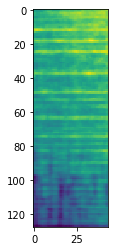

In [62]:
plt.imshow(gen_spect[5])